In [ ]:
%matplotlib inline


2-3_Transfer Learning for Computer Vision Tutorial
==============================================
In this tutorial, you will learn how to train a convolutional neural network for
image classification using transfer learning. 

Quoting these notes,

    In practice, very few people train an entire Convolutional Network
    from scratch (with random initialization), because it is relatively
    rare to have a dataset of sufficient size. Instead, it is common to
    pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
    contains 1.2 million images with 1000 categories), and then use the
    ConvNet either as an initialization or a fixed feature extractor for
    the task of interest.

These two major transfer learning scenarios look as follows:

-  **Finetuning the convnet**: Instead of random initializaion, we
   initialize the network with a pretrained network, like the one that is
   trained on imagenet 1000 dataset. Rest of the training looks as
   usual.
-  **ConvNet as fixed feature extractor**: Here, we will freeze the weights
   for all of the network except that of the final fully connected
   layer. This last fully connected layer is replaced with a new one
   with random weights and only this layer is trained.




In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

Load Data
---------

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we're going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants and bees.
There are 75 validation images for each class. Usually, this is a very
small dataset to generalize upon, if trained from scratch. Since we
are using transfer learning, we should be able to generalize reasonably
well.

This dataset is a very small subset of imagenet.




In [2]:
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip hymenoptera_data.zip

--2022-02-08 10:47:49--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 54.230.63.113, 54.230.63.24, 54.230.63.82, ...
Connecting to download.pytorch.org (download.pytorch.org)|54.230.63.113|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M  38.9MB/s    in 1.2s    

2022-02-08 10:47:51 (38.9 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]

Archive:  hymenoptera_data.zip
   creating: hymenoptera_data/
   creating: hymenoptera_data/train/
   creating: hymenoptera_data/train/ants/
  inflating: hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera_data/

In [4]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        # build your own transforms
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

### Visualize a few images
Let's visualize a few training images so as to understand the data
augmentations.



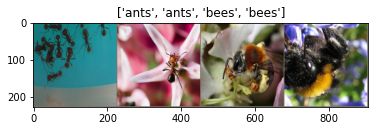

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [6]:
print(inputs.shape)

print(out.shape)

torch.Size([4, 3, 224, 224])
torch.Size([3, 228, 906])


Training the model
------------------

Now, let's write a general function to train a model.


In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.cuda()
                labels = labels.cuda()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    return model

### Visualizing the model predictions

Generic function to display predictions for a few images




In [8]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.cuda()
            labels = labels.cuda()

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [9]:
model_ft = models.resnet18(pretrained=True)

# replace the fc layer with output sample size 2
num_features = model_ft.fc.in_features

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_features, 2)

model_ft = model_ft.cuda()
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized!
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home3/indal.choi/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [10]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Train and evaluate

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [11]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6430 Acc: 0.6598
val Loss: 0.2055 Acc: 0.9281

Epoch 1/24
----------
train Loss: 0.3917 Acc: 0.8484
val Loss: 0.2106 Acc: 0.9346

Epoch 2/24
----------
train Loss: 0.5621 Acc: 0.7459
val Loss: 0.4618 Acc: 0.7908

Epoch 3/24
----------
train Loss: 0.6244 Acc: 0.7541
val Loss: 0.3885 Acc: 0.8824

Epoch 4/24
----------
train Loss: 0.8262 Acc: 0.7213
val Loss: 0.6760 Acc: 0.7974

Epoch 5/24
----------
train Loss: 0.6095 Acc: 0.8033
val Loss: 0.3686 Acc: 0.8889

Epoch 6/24
----------
train Loss: 0.5120 Acc: 0.8238
val Loss: 0.2825 Acc: 0.9020

Epoch 7/24
----------
train Loss: 0.2645 Acc: 0.8852
val Loss: 0.2905 Acc: 0.9020

Epoch 8/24
----------
train Loss: 0.2768 Acc: 0.9016
val Loss: 0.2448 Acc: 0.9150

Epoch 9/24
----------
train Loss: 0.2857 Acc: 0.8893
val Loss: 0.2677 Acc: 0.9020

Epoch 10/24
----------
train Loss: 0.3392 Acc: 0.8648
val Loss: 0.2422 Acc: 0.9150

Epoch 11/24
----------
train Loss: 0.3931 Acc: 0.8361
val Loss: 0.2286 Acc: 0.9477

Ep

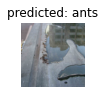

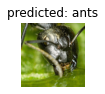

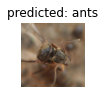

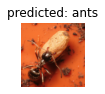

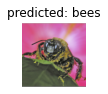

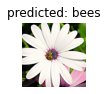

In [12]:
visualize_model(model_ft)

ConvNet as fixed feature extractor
----------------------------------

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad == False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.




In [13]:
model_conv = torchvision.models.resnet18(pretrained=True)
# freeze all the parameters of the pretrained network
for param in model_conv.parameters():
    param.requires_grad = False

# replace the pretrained fully connected layer `model_conv.fc` with a new one
num_features = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_features, 2)
model_conv = model_conv.cuda()
criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

### Train and evaluate

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [14]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6810 Acc: 0.6189
val Loss: 0.2072 Acc: 0.9477

Epoch 1/24
----------
train Loss: 0.4976 Acc: 0.7746
val Loss: 0.2987 Acc: 0.8824

Epoch 2/24
----------
train Loss: 0.5665 Acc: 0.7377
val Loss: 0.4628 Acc: 0.8170

Epoch 3/24
----------
train Loss: 0.3839 Acc: 0.8443
val Loss: 0.1635 Acc: 0.9477

Epoch 4/24
----------
train Loss: 0.3498 Acc: 0.8361
val Loss: 0.2803 Acc: 0.9216

Epoch 5/24
----------
train Loss: 0.3398 Acc: 0.8607
val Loss: 0.2851 Acc: 0.9150

Epoch 6/24
----------
train Loss: 0.4000 Acc: 0.8730
val Loss: 0.2324 Acc: 0.9150

Epoch 7/24
----------
train Loss: 0.3119 Acc: 0.8566
val Loss: 0.1637 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.3363 Acc: 0.8607
val Loss: 0.1799 Acc: 0.9346

Epoch 9/24
----------
train Loss: 0.2952 Acc: 0.8607
val Loss: 0.1943 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.3994 Acc: 0.8279
val Loss: 0.1642 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.3484 Acc: 0.8402
val Loss: 0.1735 Acc: 0.9412

Ep

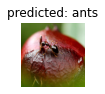

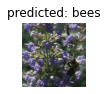

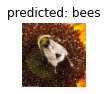

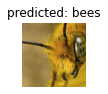

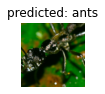

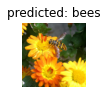

In [15]:
visualize_model(model_conv)

plt.ioff()
plt.show()